Nome: Gustavo Duarte Serafim

RA: 11054016

Disciplina: Filtragem Adaptativa

Professor: Ricardo Suyama

# Laboratório 3 - Parte 1


In [0]:
# Imports do notebook

import numpy as np
from numpy import matlib as matlab
from numpy.fft import fft
import math
from scipy.signal import lfilter as filter
import scipy.signal as signal
import matplotlib.pyplot as plt

# Trecho pra permitir gráficos interativos... (vai instalar um pacote)
#!pip install -q mpld3
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

# **Parte 1 - Estimando o valor futuro de uma senóide**

## 1. Gere um sinal senoidal, com frequência 50Hz e taxa de amostragem 8kHz. Considere um número de amostras equivalente a um trecho de 1 segundo. 


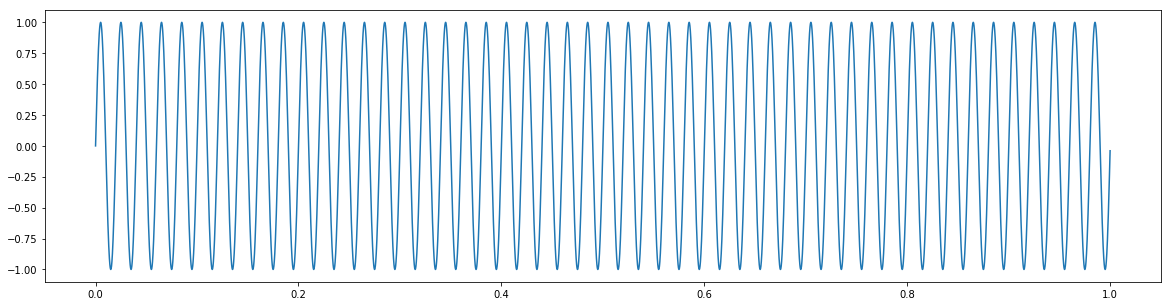

In [0]:
# Parâmetros do sinal
Fs = 8000 # Freq. de amostragem
f = 50   # Freq.
T = 1     # Período (segundos)

t = np.arange(0, T, 1/Fs)
x = np.sin(2*np.pi*f*t)  

plt.figure(figsize = [20, 5])
plt.plot(t, x)
plt.show()

## 2. Projete um preditor usando LMS ou NLMS.

In [0]:
# Parte a - Modelagem dos sinais atrasados

# Parâmetros

atrasos = [100, 50, 25, 10, 1]
x_atrasado = [0 for i in range(0, len(atrasos))]
t_atrasado = [0 for i in range(0, len(atrasos))]
x_original = [0 for i in range(0, len(atrasos))]
d = [0 for i in range(0, len(atrasos))]

plt.figure(figsize = [20, 20])

for i in range(0, len(atrasos)): 
  atraso = atrasos[i]
  num = np.zeros(atraso) 
  num[atraso-1] = 1 # Numerador da função de transferência: [0 0 0 0 ... 0 1]

  # Cálculo do sinal atrasado + eliminação do sinal indesejado (primeiros indices)
  x_atrasado[i] = filter(num, [1], x) # filtrando x(n-d)
  x_atrasado[i] = x_atrasado[i][atraso:len(x_atrasado[i])]
  t_atrasado[i] = t[atraso:len(t)]                   # cálculo de t(n-d)
  x_original[i] = x[atraso:len(x)]                   # cáçculo de x(n-d)
  d[i] = x_original[i]                               # definição do sinal desejado

  plt.subplot(5, 1, i+1)
  plt.plot(t_atrasado[i], x_atrasado[i], label = 'Sinal original')
  plt.plot(t_atrasado[i], x_original[i], 'r--', label = 'Sinal atrasado')
  #plt.xlim(t_atrasado[i][0], t_atrasado[i][-1])
  plt.legend(loc = 'upper left')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Parte b - Implementação da Função do algoritmo LMS 

def Least_Mean_Square(x, d, L = 2, mu = 0.001, partida = [0 for n in range(0, 100)]): 
  #Obs: a inicialização da partida é uma gambiarra pra funcionar até 100 coeficientes... 

  nCoeffs = L
  partida = partida[0:L]

  # Construindo a matriz X dos coeficientes de x(n) ... x(n-L+1): 
  X = matlab.repmat(x.transpose(), nCoeffs, 1)
  for i in np.arange(0, nCoeffs): 
    X[i][:] = np.roll(X[i][:], [0, i-nCoeffs+1])
  X = X[:, 0:np.size(X, 1)-nCoeffs+1]

  # O mesmo com d(n)
  d = d[nCoeffs-1:d.size]
  
  # Inicialização do filtro 
  w_LMS = np.zeros((nCoeffs,1))
  w_LMS[:, 0] = partida

  # Inicialização da matriz que armazenará a evolução dos valores de w_SD
  w_LMS_hist = np.zeros((nCoeffs,X[0].size))

  for i in range(0, X[0].size): 
    y_LMS = np.dot(w_LMS.transpose(), X[:, i])
    e = d[i] - y_LMS;
    w_LMS = w_LMS + 2*mu*X[:, i].reshape(nCoeffs,1)*e;
    w_LMS_hist[:, i] = w_LMS.reshape(nCoeffs,)

  return w_LMS, w_LMS_hist

# 3. Mostre o que ocorre em diferentes condições de:
* Número de parâmetros do preditor;
* Horizonte de predição (altere o valor de d)
* Passo de adaptação do preditor

## 3.1 Implementação do preditor com número de parâmetros = 2 e horizonte de predição variável.

In [0]:
# Parte c - Implementação do preditor variando o número de parâmetros do preditor...

# Cálculo dos coeficientes
# Passo de adaptação constante definido na função
num_param = [2]
i = 0

fig_index = 1
plt.figure(figsize = [15, 20])

for j in range(0, len(atrasos)): 
  #for i in range(0, len(num_param)): 
  w, w_hist = Least_Mean_Square(x_atrasado[j], d[j], num_param[i])

  # Construção da função de transferência do filtro FIR
  num = [w[i][0] for i in range(0, len(w))]  # [w(0), w(1), w(2), ... , w(L-1)]

  y = filter(num, [1], x_atrasado[j]) # Calculando a saída y = w*x(n-d)

  plt.subplot(5, 2, fig_index)
  plt.plot(t_atrasado[j], x_original[j], label = 'Sinal original')
  plt.plot(t_atrasado[j], y, 'r--', label = 'Sinal recuperado')
  plt.title('Sinal de saída para L = '+str(num_param[0])+' com d = '+str(atrasos[j]), fontsize = 14, )
  plt.legend(loc = 'upper left')
  fig_index = fig_index+1

  plt.subplot(5, 2, fig_index)
  plt.title('Diferença entre o sinal original e o recuperado', fontsize = 14, )
  plt.plot(t_atrasado[j], x_original[j]-y)
  plt.ylim(-1.1, 1.1)
  #plt.plot(t_atrasado, y, color = 'red', marker = '.')
  fig_index = fig_index+1

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 3.2 Implementação do preditor com horizonte de predição constante e número de parâmetros do filtro variável.

In [0]:
# Parte c - Implementação do preditor variando o número de parâmetros do preditor...

# Cálculo dos coeficientes
# Passo de adaptação constante definido na função
num_param = [2, 5, 25, 50, 100]
d_index = 4

fig_index = 1
plt.figure(figsize = [15, 20])

for j in range(0, len(num_param)): 
  #for i in range(0, len(num_param)): 
  w, w_hist = Least_Mean_Square(x_atrasado[d_index], d[d_index], num_param[j])

  # Construção da função de transferência do filtro FIR
  num = [w[i][0] for i in range(0, len(w))]  # [w(0), w(1), w(2), ... , w(L-1)]

  y = filter(num, [1], x_atrasado[d_index]) # Calculando a saída y = w*x(n-d)

  plt.subplot(5, 2, fig_index)
  plt.plot(t_atrasado[d_index], x_original[d_index], label = 'Sinal original')
  plt.plot(t_atrasado[d_index], y, 'r--', label = 'Sinal recuperado')
  plt.title('Sinal de saída para L = '+str(num_param[j])+' com d = '+str(atrasos[d_index]), fontsize = 14, )
  plt.legend(loc = 'upper left')
  fig_index = fig_index+1

  plt.subplot(5, 2, fig_index)
  plt.title('Diferença entre o sinal original e o recuperado', fontsize = 14, )
  plt.plot(t_atrasado[d_index], x_original[d_index]-y)
  plt.ylim(-1.1, 1.1)
  #plt.plot(t_atrasado, y, color = 'red', marker = '.')
  fig_index = fig_index+1

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 3.2 Implementação do preditor com horizonte de predição constante, e número de parâmetros do filtro constante e passo de adaptação variável.

In [0]:
# Parte c - Implementação do preditor variando o número de parâmetros do preditor...

# Cálculo dos coeficientes
# Passo de adaptação constante definido na função
num_param = [2, 5, 25, 50, 100]
mu = [0.1, 0.05, 0.01, 0.001, 0.0001, 0.00005]
d_index = 4

fig_index = 1
plt.figure(figsize = [18, 24])
i = 2

for j in range(0, len(mu)): 
  #for i in range(0, len(num_param)): 
  w, w_hist = Least_Mean_Square(x_atrasado[d_index], d[d_index], num_param[i], mu[j])

  # Construção da função de transferência do filtro FIR
  num = [w[i][0] for i in range(0, len(w))]  # [w(0), w(1), w(2), ... , w(L-1)]

  y = filter(num, [1], x_atrasado[d_index]) # Calculando a saída y = w*x(n-d)

  plt.subplot(6, 2, fig_index)
  plt.plot(t_atrasado[d_index], x_original[d_index], label = 'Sinal original')
  plt.plot(t_atrasado[d_index], y, 'r--', label = 'Sinal recuperado')
  plt.title("Sinal de saída para L = "+str(num_param[i])+" com d = "+str(atrasos[d_index])+" e µ = "+str(mu[j]), fontsize = 14, )
  plt.legend(loc = 'upper left')
  fig_index = fig_index+1

  plt.subplot(6, 2, fig_index)
  plt.title('Diferença entre o sinal original e o recuperado', fontsize = 14, )
  plt.plot(t_atrasado[d_index], x_original[d_index]-y)
  plt.ylim(-1.1, 1.1)
  plt.xlim(0.0, 0.1)
  #plt.plot(t_atrasado, y, color = 'red', marker = '.')
  fig_index = fig_index+1

plt.show()

Output hidden; open in https://colab.research.google.com to view.